<a href="https://colab.research.google.com/github/Lucas-Buk/IMT/blob/main/SIR_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**

In [1]:
!pip install -U plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [2]:
pip install PyAstronomy

In [3]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt

import numpy as np
from datetime import datetime, timedelta

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy import optimize
from scipy.integrate import odeint

In [4]:
# Diretório de imagens
import os
if not os.path.exists("images"):
    os.mkdir("images")

In [5]:
import yaml

with open("/content/drive/MyDrive/Trabalho/Covid/state_pop.yaml", 'r') as f:
    pop = yaml.load(f)
    print(pop)

{'AC': {'population': 881935}, 'AL': {'population': 3337357}, 'AP': {'population': 845731}, 'AM': {'population': 4144597}, 'BA': {'population': 14873064}, 'CE': {'population': 9132078}, 'DF': {'population': 3015268}, 'ES': {'population': 4018650}, 'GO': {'population': 7018354}, 'MA': {'population': 7075181}, 'MT': {'population': 3484466}, 'MS': {'population': 2778986}, 'MG': {'population': 21168791}, 'PA': {'population': 8602865}, 'PB': {'population': 4018127}, 'PR': {'population': 11433957}, 'PE': {'population': 9557071}, 'PI': {'population': 3273227}, 'RJ': {'population': 17264943}, 'RN': {'population': 3506853}, 'RS': {'population': 11329605}, 'RO': {'population': 1777225}, 'RR': {'population': 605761}, 'SC': {'population': 7164788}, 'SP': {'population': 45919049}, 'SE': {'population': 2298696}, 'TO': {'population': 1572866}}


# **Dados**

Lendo e visualizando os dados do Brasil do COVID fornecidos por

- [Wesley Cota](https://github.com/wcota/covid19br)


In [6]:
# Lendo os dados online - wcota
data_path = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'

df_BR = pd.read_csv(data_path, delimiter=",") 
df_BR.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_BR.shape

(10122, 22)

# **Tratamento dos dados**

In [8]:
drop_columns = ["deaths_per_100k_inhabitants", "totalCases_per_100k_inhabitants", "deathsMS", 
                "deaths_by_totalCases", "tests_per_100k_inhabitants", "totalCasesMS", "tests"]
df_BR = df_BR.drop(columns=drop_columns)
df_BR.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,recovered,suspects,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_BR.shape

(10122, 15)

In [10]:
df_BR.date = pd.to_datetime(df_BR.date)

# **Visualização**

## Brasil

In [11]:
# Creating the correct component values
country_df = df_BR[df_BR["state"] == "TOTAL"].dropna(subset=["state"]).reset_index()
active_infected = [country_df["totalCases"].iloc[0]]
country_df["newRecovered"] = country_df["recovered"].diff()

In [12]:
country_df.newRecovered.fillna(0, inplace=True)

In [13]:
for nc, nd, nr in zip(country_df["newCases"].iloc[1:], 
                      country_df["newDeaths"].iloc[1:], 
                      country_df["newRecovered"].iloc[1:]):
    active_infected.append(active_infected[-1] + nc - nd - nr)
country_df["activeCases"] = active_infected

In [14]:
# Plotting the correct results components
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases",
    x=country_df["date"],
    y=country_df["activeCases"],
    mode='lines',
    line_shape='spline',
    line=dict(width=3)))

fig.add_trace(go.Scatter(
    name="Deaths",
    x=country_df["date"],
    y=country_df["deaths"],
    mode='lines',
    line_shape='spline'))

fig.add_trace(go.Scatter(
    name="Recovered",
    x=country_df["date"],
    y=country_df["recovered"],
    mode='lines',
    line_shape='spline'))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Date',
    legend_orientation="h", legend=dict(x=0.35, y=1.0),
    title_text="Main SIRD data components for Brazil")

fig.show()

## Estados

In [15]:
# Get the state labels
states_list = df_BR["state"].unique().tolist()
states_list.pop(states_list.index("TOTAL"))

# Plot the recovered data at each state
fig = go.Figure()

for state in states_list:
    state_df = df_BR[df_BR["state"] == state]
    fig.add_trace(go.Scatter(
        name=state,
        x=state_df["date"],
        y=state_df["recovered"],
        mode='lines',
        line_shape='spline'))
    
fig.update_layout(
    template='xgridoff',
    xaxis_title='Date',
    title_text="Recovered data collected for each state")

fig.show()

## São Paulo

In [16]:
selected_state = "SP"

local_data = df_BR[df_BR['state'] == selected_state]
local_data = local_data[local_data.recovered.notnull()]

local_data.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,recovered,suspects,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
347,13,2020-03-24,Brazil,SP,TOTAL,10,40,65,810,1.0,4572.0,NaN,NaN,NaN,NaN
375,13,2020-03-25,Brazil,SP,TOTAL,8,48,52,862,1.0,4300.0,NaN,NaN,NaN,NaN
403,13,2020-03-26,Brazil,SP,TOTAL,10,58,191,1053,1.0,14312.0,NaN,NaN,NaN,NaN
431,13,2020-03-27,Brazil,SP,TOTAL,10,68,170,1223,1.0,14312.0,NaN,NaN,NaN,NaN
459,13,2020-03-28,Brazil,SP,TOTAL,16,84,183,1406,1.0,14312.0,NaN,NaN,NaN,NaN


In [17]:
I = list()                                       # <- I(t)
R = local_data["recovered"].iloc[1:].to_numpy()  # <- R(t)
D = local_data['deaths'][1:].to_numpy()          # <- D(t)
M = local_data["newDeaths"].iloc[1:].to_numpy()  # <- M(t)
nR = np.diff(local_data["recovered"].to_numpy()) # <- dR(t)/dt
nC = local_data["newCases"].iloc[1:].to_numpy()  # <- nC(t)/dt

I = [local_data["totalCases"].iloc[1]]           # I(0)

# I(t) <- I(t-1) + newCases(t) - newMortes(t) - newRecovered(t)
for t in range(len(M)-1):
    I.append(I[-1] + nC[t] - M[t] - nR[t])
I = np.array(I)

In [18]:
# Create figure with secondary y-axis
fig = go.Figure()

# Add traces
fig.add_trace(
    go.Scatter(
        x=local_data.date,
        y=I, 
        name='Infectados',
        mode='lines',
        line_shape='spline',
        line=dict(width=2)
        ))

fig.add_trace(
    go.Scatter(
        x=local_data.date,
        y=R, 
        name='Removidos',
        mode='lines',
        line=dict(width=2),
        line_shape='spline'
        ))

fig.add_trace(
    go.Scatter(
        x=local_data.date,
        y=M, 
        name='Mortos',
        mode='lines',
        line=dict(width=2),
        line_shape='spline'
        ))
  
# Set x-axis title
fig.update_xaxes(title_text='Days')

# Set y-axes titles
fig.update_yaxes(title_text='Indivíduos')

fig.update_layout(
    template='xgridoff',
    title_text='Evolução da Covid '+selected_state,
    legend=dict(
    orientation='h',
    yanchor='bottom',
    y=1.01,
    xanchor='right',
    x=0.95
  ))

fig.show()

# **Problema**

O conjunto de equações diferenciais que caracteriza o modelo é descrito abaixo. No modelo $\beta - \text{representa a taxa de transmissão ou taxa efetiva de contato} $  e $r - \text{a taxa de remoção ou recuperação.}$ 


$$ \begin{split}
   \frac{dS(t)}{dt} & = -\beta S(t) I(t) \\
   \frac{dI(t)}{dt} & = \beta S(t) I(t) - rI(t)  \\
   \frac{dR(t)}{dt} & = r I(t)
   \end{split}$$

   Gostaríamos de identificar quais parâmetros $\beta$ e $r$ resultam num melhor ajuste do modelo para os dados de **S**, **I** e **R**

In [19]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/MyDrive/Trabalho/Covid')

# Importando o modelo SIR
from models import *

# **Estimando os parâmetros**

Para estimarmos os parâmetros do modelo $\mathbf{\beta}$ e $\mathbf{r}$, vamos utilizar  inicialmente o método de mínimos quadrados. Podemos então formular o problema a partir da Equação abaixo. Na Equação $y_m(k)$ representa o dado real em cada amostra $k$; $y_s(\theta,k)$ representa o **valor estimado** a partir da simulação do modelo para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. 

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

A equação formula a pergunta: quais os valores de $beta$ e $r$ que minizam o erro quadrático quando comparados com os dados reais.

## **Dados do Maranhão**

In [36]:
df_MA = df_BR[df_BR.state == 'MA'].reset_index()
#df_MA.recovered.fillna(0)
df_MA.head()

,index,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,recovered,suspects,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,220,12,2020-03-20,Brazil,MA,TOTAL,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,247,12,2020-03-21,Brazil,MA,TOTAL,0,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,275,13,2020-03-22,Brazil,MA,TOTAL,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
3,303,13,2020-03-23,Brazil,MA,TOTAL,0,0,6,8,NaN,302.0,NaN,NaN,NaN,NaN
4,331,13,2020-03-24,Brazil,MA,TOTAL,0,0,0,8,NaN,302.0,NaN,NaN,NaN,NaN


In [39]:
df_MA["newRecovered"] = df_MA["recovered"].diff()
df_MA.newRecovered.fillna(0, inplace=True)
df_MA.recovered.fillna(0, inplace=True)
df_MA.head()

,index,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,recovered,suspects,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants,newRecovered
0,220,12,2020-03-20,Brazil,MA,TOTAL,0,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,0.0
1,247,12,2020-03-21,Brazil,MA,TOTAL,0,0,1,2,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,275,13,2020-03-22,Brazil,MA,TOTAL,0,0,0,2,0.0,NaN,NaN,NaN,NaN,NaN,0.0
3,303,13,2020-03-23,Brazil,MA,TOTAL,0,0,6,8,0.0,302.0,NaN,NaN,NaN,NaN,0.0
4,331,13,2020-03-24,Brazil,MA,TOTAL,0,0,0,8,0.0,302.0,NaN,NaN,NaN,NaN,0.0


In [40]:
active_infected = [df_MA["totalCases"].iloc[0]]
for nc, nd, nr in zip(df_MA["newCases"].iloc[1:], 
                      df_MA["newDeaths"].iloc[1:], 
                      df_MA["newRecovered"].iloc[1:]):
    active_infected.append(active_infected[-1] + nc - nd - nr)
df_MA["activeCases"] = active_infected

df_MA.head()

,index,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,recovered,suspects,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants,newRecovered,activeCases
0,220,12,2020-03-20,Brazil,MA,TOTAL,0,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0
1,247,12,2020-03-21,Brazil,MA,TOTAL,0,0,1,2,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2.0
2,275,13,2020-03-22,Brazil,MA,TOTAL,0,0,0,2,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2.0
3,303,13,2020-03-23,Brazil,MA,TOTAL,0,0,6,8,0.0,302.0,NaN,NaN,NaN,NaN,0.0,8.0
4,331,13,2020-03-24,Brazil,MA,TOTAL,0,0,0,8,0.0,302.0,NaN,NaN,NaN,NaN,0.0,8.0


In [51]:
# Tamanho da população - N
N = pop['MA']['population']

I = list()                            # <- I(t)
R = df_MA["recovered"].to_numpy(dtype='int64')     # <- R(t)
D = df_MA['deaths'].to_numpy(dtype='int64')        # <- D(t)
M = df_MA["newDeaths"].to_numpy(dtype='int64')     # <- M(t)
nR = df_MA["newRecovered"].to_numpy(dtype='int64') # <- dR(t)/dt
nC = df_MA["newCases"].to_numpy(dtype='int64')     # <- nC(t)/dt

I = [df_MA["totalCases"].iloc[0]]     # I(0)

# I(t) <- I(t-1) + newCases(t) - newMortes(t) - newRecovered(t)
for t in range(len(M)-1):
    I.append(I[-1] + nC[t] - M[t] - nR[t])
I = np.array(I)

S = N - I - R - D

In [59]:
dataset = pd.DataFrame(S, columns=['S'])
dataset['I'] = I
dataset['R'] = R
dataset['D'] = D

In [58]:
sir_model = ss.SIR(pop=N, focus=["I", "R"])

In [ ]:
time = np.linspace(0, len(I), len(I))

# Estimando os parâmetros
dataset = pd.DataFrame(S, columns=['S'])
dataset['I'] = I
dataset['R'] = R
dataset['D'] = D

sir_model.fit(dataset, time, sample_ponder=True), resample=True, beta_sens=[1000,10], r_sens=[1000,10])

r_included = True

In [ ]:
sir_model.parameters[0]/sir_model.parameters[1] # Ro <- \beta * (1 / \r)

In [ ]:
# Criando a figura
p1 = figure(plot_height=500,
           plot_width=600,
           x_axis_type="datetime", 
           tools="", 
           toolbar_location=None,
#            y_axis_type="log",
           title="Evolução do COVID - São Paulo")

# Preparando o estilo
p1.grid.grid_line_alpha = 0
p1.ygrid.band_fill_color = "olive"
p1.ygrid.band_fill_alpha = 0.1
p1.yaxis.axis_label = "Indivíduos"
p1.xaxis.axis_label = "Dias"

# Incluindo as curvas
p1.line(time, I, legend_label="Infectados", line_cap="round", line_width=3, color="#ffd885")
#p1.line(time, , legend_label="Mortes", line_cap="round", line_width=3, color="#de425b")
p1.line(time, R, legend_label="Removidos", line_cap="round", line_width=3, color="#99d594")

p1.scatter(sir_model.pipeline["resample"]["after"]["t"], 
           sir_model.pipeline["resample"]["after"]["I"], 
           marker="circle",line_color="#6666ee", fill_color="#ee6666", fill_alpha=0.5, size=3)

p1.scatter(sir_model.pipeline["resample"]["after"]["t"], 
           sir_model.pipeline["resample"]["after"]["R"], 
           marker="circle",line_color="#6666ee", fill_color="#ee6666", fill_alpha=0.5, size=3)

# Colocando as legendas
p1.legend.click_policy="hide"
p1.legend.location = "top_left"


show(p1)

In [ ]:
if r_included:
    initial = [S[0], I[0], R[0]]
else:
    initial = [S[0], I[0]]
    
results = sir_model.predict(initial, time)

In [ ]:
# Incluindo os dados de infectados
im_p = p.line(
    date_vec, results[1],
    legend_label="Infectados - Modelo",
    line_width=4,
    line_dash="dashed",
    line_cap="round",
    color="#f57f17"
)

# Incluindo os dados de recuperados
if r_included:
    rm_p = p.line(
        date_vec, results[2],
        legend_label="Removidos - Modelo",
        line_dash="dashed",
        line_width=4,
        line_cap="round",
        color="#1b5e20"
    )

show(p)

# **Predições utilizando o modelo**

In [ ]:
# Criando os valores de tempo para previsão - 120 dias
t_sim = np.linspace(0, len(I) + 120, len(I) + 120)
date_vec_sim = [first_date + timedelta(days=k) for k in t_sim]

# Prevendo para os valores selecionados
prediction = sir_model.predict(initial, t_sim)



# Criando o gráfico com as predições

# Criando os valores para legenda no plot
year_sim =  [str(int(d.year)) for d in date_vec_sim ]
month_sim = [("0"+str(int(d.month)))[-2:] for d in date_vec_sim ]
day_sim =   [("0"+str(int(d.day)))[-2:] for d in date_vec_sim ]

if r_included:
    accum_Infect = [0]
    for i in N - prediction[1] - prediction[2]:
        accum_Infect.append(accum_Infect[-1]+i)

    accum_Infect = sir_model.parameters[1] * np.array(accum_Infect)
    
# Criando a fonte de dados
if r_included:
    source = ColumnDataSource(data={
        'Data'       : date_vec,
        'd': day, 'm': month, 'y': year,
        'Infectados' : I,
        'Removidos'  : R,
        'Mortes'     : M,
        'InfecModelo' : prediction[1],
        'RemovModelo' : prediction[2],
        'AccumInfect' : accum_Infect,
        'SucetModelo' : N - prediction[1] - prediction[2],
        'DataModelo'  : date_vec_sim,
        'ds': day_sim, 'ms': month_sim, 'ys': year_sim
    })
else:
    source = ColumnDataSource(data={
        'Data'       : date_vec,
        'd': day, 'm': month, 'y': year,
        'Infectados' : I,
        'Removidos'  : R,
        'Mortes'     : M,
        'InfecModelo' : prediction[1],
        'DataModelo'  : date_vec_sim,
        'ds': day_sim, 'ms': month_sim, 'ys': year_sim
    })

    
# Criando a figura
p = figure(plot_height=700,
           plot_width=800,
           x_axis_type="datetime", 
           tools="", 
           toolbar_location=None,
           y_axis_type="log",
           title="Previsão do COVID - Brasil")

# Preparando o estilo
p.grid.grid_line_alpha = 0
p.ygrid.band_fill_color = "olive"
p.ygrid.band_fill_alpha = 0.1
p.yaxis.axis_label = "Indivíduos"
p.xaxis.axis_label = "Dias"

# Incluindo as curvas
i_p = p.line(x='Data', y='Infectados', legend_label="Infectados", line_cap="round", line_width=3, color="#ffd885", source=source)
m_p = p.line(x='Data', y='Mortes', legend_label="Mortes", line_cap="round", line_width=3, color="#de425b", source=source)
r_p = p.line(x='Data', y='Removidos', legend_label="Removidos", line_cap="round", line_width=3, color="#99d594", source=source)

mp_p = p.line(x='DataModelo', y='InfecModelo', legend_label="Infectados - Modelo", line_dash="dashed", line_cap="round", line_width=4, color="#f57f17", source=source)

renders = [i_p, m_p, r_p, mp_p]

if r_included:
    rp_p = p.line(x='DataModelo', y='RemovModelo', legend_label="Removidos - Modelo", line_dash="dashed", line_cap="round", line_width=4, color="#1b5e20", source=source)
    renders.append(rp_p)
    
# Colocando as legendas
p.legend.click_policy="hide"
p.legend.location = "top_left"

# Incluindo a ferramenta de hover
p.add_tools(HoverTool(
    tooltips=[
        ( 'Indivíduos', '$y{0.00 a}' ),
        ( 'Data',       '@ds/@ms/@ys'),
    ],
    renderers=renders
))

show(p)

# **Modelo SIR**

In [ ]:
def SIRmodel(y, t, Beta, r):
    S, I, R = y
    Sdot = -(Beta * S * I)
    Idot = (Beta * S * I)  - r * I
    Rdot = r * I
    return Sdot, Idot, Rdot   

# Resolução da simulação - Escala temporal (dias)

In [ ]:
def SIRsim(y0, t, theta):
    Beta = theta[0]
    r = theta[1]
    ret = odeint(SIRmodel,y0,t,args=(Beta,r))
    S, I, R = ret.T
    return S, I, R

## **Parâmetros**

In [ ]:
def ErroQuadratico(Sd, Id, Rd, y0, t, theta0):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    [S,I,R] = SIRsim(y0,t,theta0)
    erroS = S - Sd
    erroI = I - Id
    erroR = R - Rd
    EQ = np.concatenate([erroI,erroR])
    return EQ

def objetivo(p):
    return ErroQuadratico(Sd,Id,Rd,y0,t,p)

In [ ]:
(c, kvg) = optimize.leastsq(objetivo,theta0) 
print(c)

## **Visualização**

In [ ]:
# Plotting the correct results components
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases",
    x=t,
    y=df_MA["activeCases"],
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered",
    x=t,
    y=df_MA["recovered"],
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.add_trace(go.Scatter(
    name="Model - Suceptible",
    x=t,
    y=Sa,
    mode="lines",
    line=dict(width=3, dash="dash", color="#0288d1")
    ))

fig.add_trace(go.Scatter(
    name="Model - Recovered",
    x=t,
    y=Ra,
    mode="lines",
    line=dict(width=3, dash="dash", color="#2e7d32")
    ))

fig.add_trace(go.Scatter(
    name="Model - Active cases",
    x=t,
    y=Ia,
    mode="lines",
    line=dict(width=3, dash="dash", color="#6a1b9a")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Date',
    #legend_orientation="h", legend=dict(x=0.35, y=1.0),
    title_text="Model prediction on Maranhão Brazil")

fig.show()

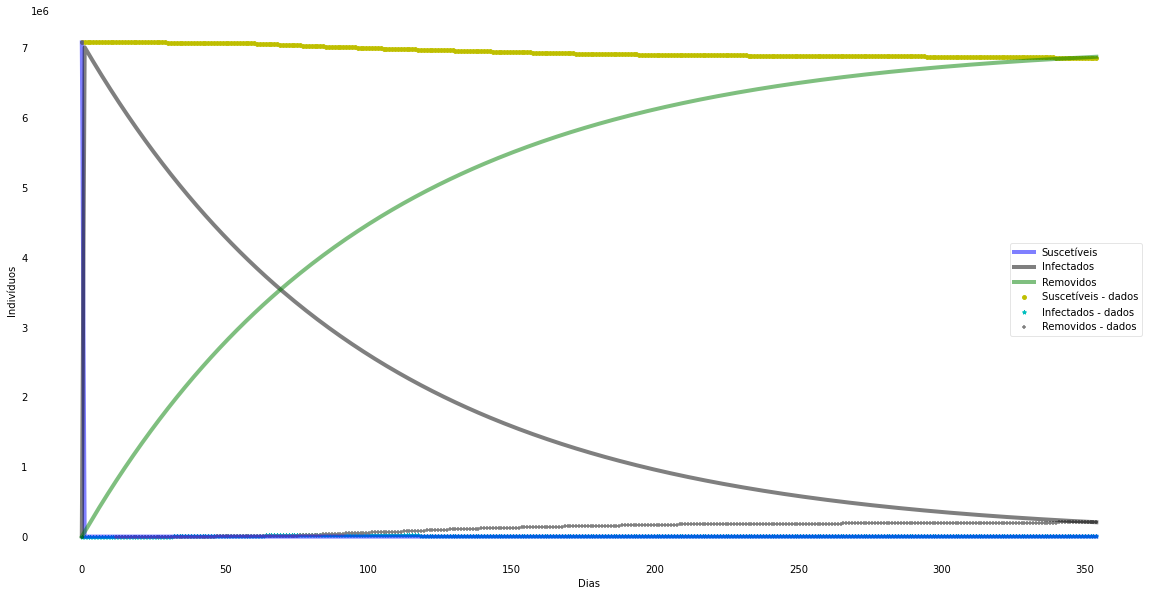

In [ ]:
[Sa,Ia,Ra] = SIRsim(y0,t,c)

# Visualizando a evolução da Epidemia - S(t), I(t) e R(t)
fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, Sa, 'b', alpha=0.5, lw=4, label='Suscetíveis')
ax.plot(t, Ia, 'k', alpha=0.5, lw=4, label='Infectados')
ax.plot(t, Ra, 'g', alpha=0.5, lw=4, label='Removidos')
plt.scatter(t, Sd, marker='o', color='y', label='Suscetíveis - dados', s=15)
plt.scatter(t, Id, marker='*', color='c', label='Infectados - dados', s=15)
plt.scatter(t, Rd, marker='+', color='gray', label='Removidos - dados', s=15)
ax.set_xlabel('Dias')
ax.set_ylabel('Indivíduos')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# **Referências**


- [Predictive Monitoring of COVID-19](https://ddi.sutd.edu.sg)

- [Apple mobility data](https://www.apple.com/covid19/mobility)

- [Corona Virus - Brazil Data](https://painel.covid19br.org)

- [Fitting model to Corona Virus](https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7)

- [Kaggle](https://www.kaggle.com/marcelolafeta/covid-brazil-local-predictions-heuristic-learning/notebook)

- [GitHub](https://github.com/lafetamarcelo/epidemicModels)

